# Predicting grayscale images of letters P - Z.

The assignment consists on the prediction of grayscale images of letters P - Z.

The data can be loaded as follows:

import pickle 

```
x_train = pickle.load(open("x_train.obj","rb"))

x_test = pickle.load(open("x_test.obj","rb"))

y_train = pickle.load(open("y_train.obj","rb"))
```

The provided data comprises the training set that can be used for the training (and for the validation) and the unlabelled balanced test set.

In [1]:
import keras
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
import tensorflow
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
%matplotlib inline
RANDOM_SEED = 37117
np.random.seed(RANDOM_SEED)

##Inspecting the data

any comment about data dimensionality/distribution goes here

x_train dimention: (14000, 28, 28)
y_train dimention: (14000,)
x_test dimention: (8800, 28, 28)

Some examples of images from the dataset: 


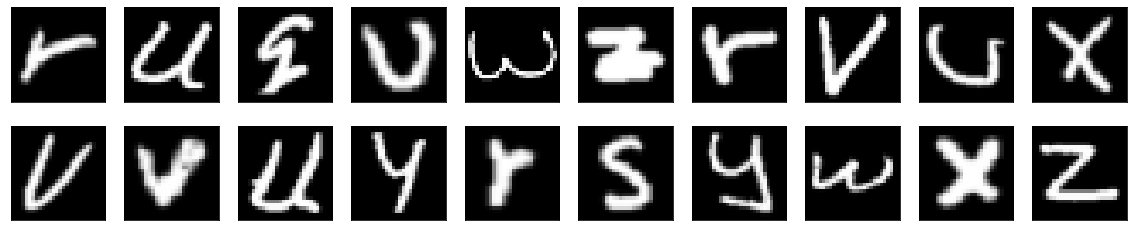


Corresponding labels(directly as encoded in y_train):
[18 21 17 21 23 26 18 22 21 24]
[22 22 21 25 18 19 25 23 24 26]

Corresponding labels(in letters): 
r u q u w z r v u x 
v v u y r s y w x z 

In [2]:
# uploading data
x_train = pickle.load(open("x_train.obj","rb"))
x_test = pickle.load(open("x_test.obj","rb"))
y_train = pickle.load(open("y_train.obj","rb"))

# Input images dimention
print('x_train dimention: ' + str(x_train.shape))
print('y_train dimention: ' + str(y_train.shape))
print('x_test dimention: ' + str(x_test.shape))

# Visualizing first 20 letters in trainset and corresponging labels
print('\nSome examples of images from the dataset: ')
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(x_train[i])

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    bx = plt.subplot(2, 10, i+11)
    plt.imshow(x_train[i+10])
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

print('\nCorresponding labels(directly as encoded in y_train):' )
print(y_train[:10])
print(y_train[10:20])

print('\nCorresponding labels(in letters): ')
a = np.full((1, 20), ord('p') - 16, dtype=int)
for i in range(20):
  if i == 10:
    print()
  print(chr(y_train[i] + a[0][i]) + ' ', end = '')

Controllo che i dati siano tutti validi e come ci si aspetta che siano:

In [3]:
# null images check
zerosImage = 0
nullImage = np.zeros((28,28),dtype=np.int8)
for im in x_train:
  if sum(sum(nullImage)) == sum(sum(im)):
    zerosImage = zerosImage + 1
print('Number of null images: ' + str(zerosImage))

# check of labels (looking for values ​​that are not contemplated)
badLabel = 0
asd = 0
for lab in y_train:
  if (lab < 16 or lab > 26) :
    badLabel = badLabel + 1
print('Number of not contemplated labels: ' + str(badLabel))


Number of null images: 0
Number of not contemplated labels: 0


Analisi della distribuzione dei dati rispetto alle labels:

In [4]:
label_occurrences = np.bincount(y_train)
print(label_occurrences[16:27])
print('Number of categories:',len(set(y_train)))

[1295 1265 1346 1329 1336 1297 1269 1327 1322 1321  893]
Number of categories: 11


Le classi risultano ben bilanciate, ad eccezione, in piccola misura, della classe corrispondente alla lettera Z. Non ricorro a tecniche di ribilanciamento dei dati perchè la differenza nella cardinalità delle classi non risulta così marcata.

## Preparing the data

Si sono normalizzati i valori dei pixel tra 0 e 1 ed è stata eseguita la one hot encode sui valori di classificazione.

In [5]:
X_train = x_train.reshape(14000, 784)#28x28
X_test = x_test.reshape(8800, 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# normalization, pixel in [0,1]
X_train /= 255
X_test /= 255

# one hot encode
Y_train =  np_utils.to_categorical([x - 16 for x in y_train], 11, dtype='float32')
print(Y_train[0])
print(y_train[0])
print(X_train.shape)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
18
(14000, 784)


#### Split Training and Validation Data

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(10500, 784)
(10500, 11)
(3500, 784)
(3500, 11)


# 1. The resolution of the problem of supervised classification with a traditional neural network [Mandatory]


## Building the network

Ho deciso di creare una rete con livelli di numerosità decrescente per, idealmente, far convergere all'ultimo livello le feature più importanti in pochi neuroni. Ho utilizzato la relu come funzione di attivazione perchè efficace e veloce. All'ultimo livello invece si è utilizzata la softmax function, poichè si ha un problema di classificazione in 11 classi. Il metodo di ottimizzazione utilizzato è il stocastic gradient descend, mentre la loss function utilizzata è la categorical_crossentropy, poichè si ha a che fare con un problema di classificazione tra più categorie. Si è utilizzata la tecnica di regolazizzazione L2(weight decay) per evitare il problema dell'overfitting. Il leaning rate è stato settato a 0.001, piccolo per rendere la convergenza più stabile, associato ad un numero di epochs piuttosto elevato: 1000. Oltre le 1000 epochs il margine di guadagno andava ad essere praticamente ininfluente e a rendere l'algoritmo troppo lento.


Commento: Un altro tipo di regolarizzazione che si sarebbe potuto fare, molto adatto alle immagini ed intuitivo è la data augmentation. In particolare si sarebbe potuto arricchire il set iniziale con immagini leggermente ruotate/traslate, binarizzate, si sarebbe potuto lavorare sugli edge e molto altro.

In [7]:
dims = X_train.shape[1]
print(dims)
nb_classes = 11
initializer = tf.keras.initializers.GlorotUniform(seed=1234)

model_l2 = Sequential()
model_l2.add(Dense(512, input_shape=(dims,), activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(256, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(32, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(16, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(nb_classes, activation = "softmax"))

n_epochs = 1000
n_batch_size = 128
model_l2.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
model_l2_history = model_l2.fit(X_train, Y_train, batch_size=n_batch_size, 
                            epochs=n_epochs, verbose=2, validation_data=(X_val, Y_val))

784


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/1000
83/83 - 2s - loss: 12.7113 - accuracy: 0.1170 - val_loss: 12.6912 - val_accuracy: 0.1169 - 2s/epoch - 21ms/step
Epoch 2/1000
83/83 - 1s - loss: 12.6649 - accuracy: 0.1317 - val_loss: 12.6446 - val_accuracy: 0.1323 - 505ms/epoch - 6ms/step
Epoch 3/1000
83/83 - 0s - loss: 12.6195 - accuracy: 0.1454 - val_loss: 12.5997 - val_accuracy: 0.1471 - 443ms/epoch - 5ms/step
Epoch 4/1000
83/83 - 0s - loss: 12.5752 - accuracy: 0.1592 - val_loss: 12.5556 - val_accuracy: 0.1609 - 449ms/epoch - 5ms/step
Epoch 5/1000
83/83 - 0s - loss: 12.5317 - accuracy: 0.1739 - val_loss: 12.5119 - val_accuracy: 0.1766 - 495ms/epoch - 6ms/step
Epoch 6/1000
83/83 - 0s - loss: 12.4883 - accuracy: 0.1852 - val_loss: 12.4680 - val_accuracy: 0.1943 - 495ms/epoch - 6ms/step
Epoch 7/1000
83/83 - 1s - loss: 12.4445 - accuracy: 0.2037 - val_loss: 12.4235 - val_accuracy: 0.2080 - 506ms/epoch - 6ms/step
Epoch 8/1000
83/83 - 1s - loss: 12.4001 - accuracy: 0.2176 - val_loss: 12.3784 - val_accuracy: 0.2286 - 506ms/epo

## Analyze and comment the training results & Validate the model and comment the results

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 11)                187       
                                                                 
Total params: 542,187
Trainable params: 542,187
Non-trainable params: 0
_________________________________________________________________


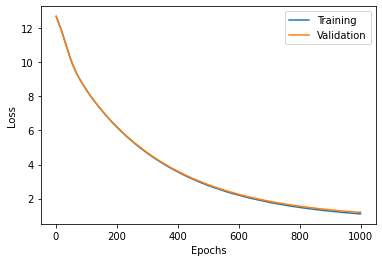

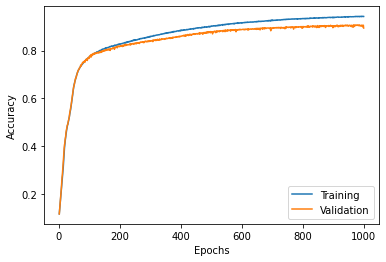

In [8]:
model_l2.summary()

x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(model_l2_history)

I commenti sui grafici sono implicitamente già stati fatti in parte nella scelta degli iperparametri. Possiamo comunque notare come la curva della loss sia decrescente: indicatore positivo. L'accuracy invece è crescente e tra training e validation non abbiamo divergenza: segnale positivo perchè non c'è overfitting. Volendo risparmiare sul tempo di training avremmo potuto anche dimezzare le epochs, poichè il guadagno nelle ultime 500 epochs vale solo 1-2 punti percentuali sul validation set.

In [9]:
# calcolo di performance score(su val set)
score = model_l2.evaluate(X_val, Y_val, batch_size=n_batch_size)
print("\n%s: %.2f%%" % (model_l2.metrics_names[1], score[1]*100))
print("\n%s: %.2f" % (model_l2.metrics_names[0], score[0]))

28/28 [==============================] - 0s 4ms/step - loss: 1.2081 - accuracy: 0.8940

accuracy: 89.40%

loss: 1.21


In [10]:
val_predictions = model_l2.predict(X_val)
val_classes_pred=np.argmax(val_predictions,axis=1)
print(val_classes_pred[:20])
val_true_values=np.argmax(Y_val,axis=1)
print(val_true_values[:20])

[7 1 9 4 1 1 6 0 7 1 2 7 1 3 3 3 6 6 5 9]
[7 3 6 4 0 1 6 0 7 1 2 7 1 1 3 3 6 6 5 9]


In [11]:
from sklearn.metrics import classification_report
print(classification_report(val_true_values,val_classes_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       318
           1       0.87      0.87      0.87       334
           2       0.88      0.84      0.86       308
           3       0.96      0.92      0.94       326
           4       0.83      0.96      0.89       335
           5       0.92      0.85      0.88       306
           6       0.89      0.82      0.85       328
           7       0.90      0.95      0.92       325
           8       0.95      0.90      0.92       347
           9       0.82      0.89      0.85       341
          10       0.97      0.87      0.92       232

    accuracy                           0.89      3500
   macro avg       0.90      0.89      0.89      3500
weighted avg       0.90      0.89      0.89      3500



Non c'è una grande diffrenza tra le misure di performance sulle differenti classi. Notiamo solo che la precision migliore è quella della classe 'Z'(10), nonostante il suppporto sia quello più piccolo nel dataset. La precision peggiore è invece quella della classe 'Y'(9).

## Make predictions (on the provided test set)

Ci si aspetta quindi che il modello si comporti bene anche sul test set, senza differenze significative tra le varie classi.

In [23]:
test_predictions = model_l2.predict(X_test)
test_classes_pred=np.argmax(val_predictions,axis=1)
print(test_classes_pred[:20])

[7 1 9 4 1 1 6 0 7 1 2 7 1 3 3 3 6 6 5 9]


## [OPTIONAL] -- Export the predictions in the format indicated in the assignment release page.

In [33]:
format_test_classes_pred = [x + 16 for x in test_classes_pred]
print(format_test_classes_pred[:20])

textfile = open("Andrea_Premate_829777_score2.txt", "w")
for element in format_test_classes_pred:
  textfile.write(str(element) + "\n")
textfile.close()

[23, 17, 25, 20, 17, 17, 22, 16, 23, 17, 18, 23, 17, 19, 19, 19, 22, 22, 21, 25]


# 2. The developement of a simple auto-encoder model  [Mandatory]


## Building the network

Si è utilizzato un autoencoder di complessivamente 3 layers. Con un numero di epochs tra 50-100 si ottengono mse e loss di validation e train che sono stabilizzati su un valore costante e sono simili tra loro, fatto positivo.

In [12]:
encoding_dim = 32
input_img = Input(shape=(784,)) #28 x28 
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

In [13]:
encoder = keras.Model(input_img, encoded)

In [14]:
encoding_dim = 32
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [15]:
from tensorflow.keras.optimizers import SGD 
autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics = ["mse"])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_5 (Dense)             (None, 32)                25120     
                                                                 
 dense_6 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.fit(X_train,X_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/100
83/83 [==============================] - 1s 9ms/step - loss: 0.4332 - mse: 0.1100 - val_loss: 0.3377 - val_mse: 0.0768
Epoch 2/100
83/83 [==============================] - 0s 6ms/step - loss: 0.3135 - mse: 0.0681 - val_loss: 0.2895 - val_mse: 0.0596
Epoch 3/100
83/83 [==============================] - 1s 7ms/step - loss: 0.2729 - mse: 0.0538 - val_loss: 0.2578 - val_mse: 0.0487
Epoch 4/100
83/83 [==============================] - 1s 7ms/step - loss: 0.2475 - mse: 0.0450 - val_loss: 0.2374 - val_mse: 0.0416
Epoch 5/100
83/83 [==============================] - 0s 6ms/step - loss: 0.2297 - mse: 0.0389 - val_loss: 0.2217 - val_mse: 0.0362
Epoch 6/100
83/83 [==============================] - 0s 5ms/step - loss: 0.2154 - mse: 0.0341 - val_loss: 0.2093 - val_mse: 0.0321
Epoch 7/100
83/83 [==============================] - 1s 6ms/step - loss: 0.2042 - mse: 0.0304 - val_loss: 0.1994 - val_mse: 0.0289
Epoch 8/100
83/83 [==============================] - 0s 5ms/step - loss: 0.1953 - m

## Inspecting the visual results 


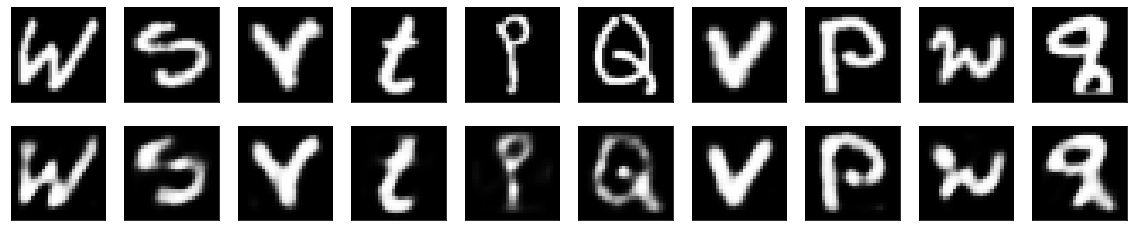

In [17]:
X_selected = X_val
encoded_imgs = encoder.predict(X_selected)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_selected[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visivamente, come si poteva intuire dal commento precedente, si ottengono risultati buoni, nonostante la compressione di un fattore 24.5.

# 3. [OPTIONAL] The use and evaluation of the encoded representation generated by the auto-encoder to solve the problem of supervised classification.

In questa sezione si è utilizzata la compressione del passo precedente come input ad un classificatore. Il nuovo classificatore scelto è nuovamente una NN, con dimensioni ridotte rispetto a quella del punto 1 (ma forma simile), poichè la dimensione di input in questo caso è notevolmente ridotta. Si è scelto un numero di epochs inferiore per lo stesso motivo.

In [18]:
encoded_X_train = encoder.predict(X_train)
encoded_X_val = encoder.predict(X_val)
print(encoded_X_train.shape)
print(encoded_X_val.shape)

initializer = tf.keras.initializers.GlorotUniform(seed=1234)
model_l2_enc = Sequential()
model_l2_enc.add(Dense(128, input_shape=(encoding_dim,), activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2_enc.add(Dense(64, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2_enc.add(Dense(32, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2_enc.add(Dense(16, activation = "relu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_l2_enc.add(Dense(nb_classes, activation = "softmax"))

n_epochs = 500
n_batch_size = 128
model_l2_enc.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
model_l2_enc_history = model_l2_enc.fit(encoded_X_train, Y_train, batch_size=n_batch_size, 
                            epochs=n_epochs, verbose=2, validation_data=(encoded_X_val, Y_val))

(10500, 32)
(3500, 32)
Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


83/83 - 1s - loss: 4.3845 - accuracy: 0.1346 - val_loss: 4.3065 - val_accuracy: 0.1637 - 1s/epoch - 17ms/step
Epoch 2/500
83/83 - 0s - loss: 4.2622 - accuracy: 0.1908 - val_loss: 4.2405 - val_accuracy: 0.2069 - 467ms/epoch - 6ms/step
Epoch 3/500
83/83 - 0s - loss: 4.2040 - accuracy: 0.2220 - val_loss: 4.1933 - val_accuracy: 0.2363 - 397ms/epoch - 5ms/step
Epoch 4/500
83/83 - 0s - loss: 4.1531 - accuracy: 0.2537 - val_loss: 4.1543 - val_accuracy: 0.2346 - 461ms/epoch - 6ms/step
Epoch 5/500
83/83 - 0s - loss: 4.1043 - accuracy: 0.2791 - val_loss: 4.1037 - val_accuracy: 0.2786 - 445ms/epoch - 5ms/step
Epoch 6/500
83/83 - 0s - loss: 4.0543 - accuracy: 0.3017 - val_loss: 4.0399 - val_accuracy: 0.3097 - 444ms/epoch - 5ms/step
Epoch 7/500
83/83 - 0s - loss: 3.9985 - accuracy: 0.3228 - val_loss: 3.9847 - val_accuracy: 0.3303 - 382ms/epoch - 5ms/step
Epoch 8/500
83/83 - 0s - loss: 3.9378 - accuracy: 0.3482 - val_loss: 3.9301 - val_accuracy: 0.3497 - 384ms/epoch - 5ms/step
Epoch 9/500
83/83 - 0s

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 11)                187       
                                                                 
Total params: 15,275
Trainable params: 15,275
Non-trainable params: 0
_________________________________________________________________


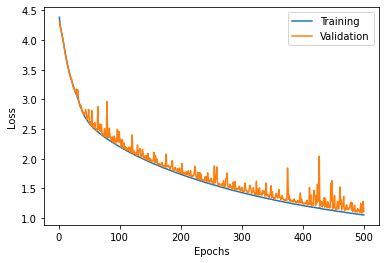

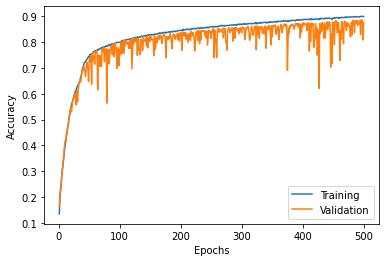

In [19]:
model_l2_enc.summary()

x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(model_l2_enc_history)

Rispetto alla NN precedente si può notare l'effetto della compressione in particolar modo sull'instabilità dei grafici, nonostante tutti gli altri commenti che sono stati fatti in precedenza rimangono validi anche in questo caso.

In [20]:
# calcolo di performance score(su val set)
score_enc = model_l2_enc.evaluate(encoded_X_val, Y_val, batch_size=n_batch_size)
print("\n%s: %.2f%%" % (model_l2_enc.metrics_names[1], score_enc[1]*100))
print("\n%s: %.2f" % (model_l2_enc.metrics_names[0], score_enc[0]))

28/28 [==============================] - 0s 5ms/step - loss: 1.1136 - accuracy: 0.8754

accuracy: 87.54%

loss: 1.11


In [21]:
val_predictions_enc = model_l2_enc.predict(encoded_X_val)
val_classes_pred_enc=np.argmax(val_predictions_enc,axis=1)
print(val_classes_pred_enc[:20])
val_true_values=np.argmax(Y_val,axis=1)
print(val_true_values[:20])

[7 1 9 4 1 1 6 0 7 1 2 7 1 8 3 3 6 6 5 9]
[7 3 6 4 0 1 6 0 7 1 2 7 1 1 3 3 6 6 5 9]


In [22]:
from sklearn.metrics import classification_report
print(classification_report(val_true_values,val_classes_pred_enc))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       318
           1       0.89      0.82      0.85       334
           2       0.83      0.84      0.84       308
           3       0.95      0.91      0.93       326
           4       0.90      0.85      0.88       335
           5       0.90      0.84      0.86       306
           6       0.82      0.89      0.86       328
           7       0.94      0.87      0.91       325
           8       0.82      0.92      0.86       347
           9       0.81      0.88      0.85       341
          10       0.90      0.89      0.89       232

    accuracy                           0.88      3500
   macro avg       0.88      0.88      0.88      3500
weighted avg       0.88      0.88      0.88      3500



Anche per quanto riguarda le performance tra le varie classi non ci sono grandi differenze così come nel punto 1.

## Confronto
La prima rete ha circa il 2% in più di accuracy rispetto alla seconda. A parte qualche piccolo punto percentuale nelle misure di performance abbiamo però che le distribuzioni di queste ultime si assomigliano molto nella forma. La compressione è quindi da considerare soddisfacente, oltre che visivamente, anche dal punto di vista della classificazione. In questo toy-problem non c'è un grande motivo ad utilizzare questa tecnica, ma immagino che la situazione possa cambiare in un contesto in cui i dati sono più pesanti e numerosi.